In [2]:
import os

TRAIN_PATH = "/kaggle/input/datasets/harshit1631/mixeddatasetcapsularendoscopy1/Dataset/training"
VAL_PATH   = "/kaggle/input/datasets/harshit1631/mixeddatasetcapsularendoscopy1/Dataset/validation"

print("Train folders:", os.listdir(TRAIN_PATH)[:])

Train folders: ['Erythema', 'Foreign Body', '~$training_data.xlsx', 'Bleeding', 'Lymphangiectasia', 'Normal', 'training_data.xlsx', 'Angioectasia', 'Erosion', 'Ulcer', 'Polyp', 'Worms']


In [3]:
from torch.utils.data import Dataset
from PIL import Image

class EndoscopyDataset(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.transform = transform
        
        classes = sorted([
            c for c in os.listdir(root)
            if os.path.isdir(os.path.join(root,c))
        ])
        self.classes = classes
        self.class_to_idx = {c:i for i,c in enumerate(classes)}

        for cls in classes:
            class_dir = os.path.join(root,cls)

            for sub in os.listdir(class_dir):
                sub_path = os.path.join(class_dir,sub)
                if not os.path.isdir(sub_path):
                    continue

                for f in os.listdir(sub_path):
                    if f.lower().endswith((".jpg",".png",".jpeg")):
                        self.samples.append(
                            (os.path.join(sub_path,f),
                             self.class_to_idx[cls])
                        )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,i):
        path,label = self.samples[i]
        img = Image.open(path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img,label

In [4]:
from torchvision import transforms

train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

In [5]:
train_ds = EndoscopyDataset(TRAIN_PATH, train_tf)
val_ds   = EndoscopyDataset(VAL_PATH, val_tf)

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Classes:", train_ds.classes)

Train size: 37607
Val size: 16132
Classes: ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']


In [6]:
import numpy as np
import torch

labels = [label for _,label in train_ds.samples]
counts = np.bincount(labels)

weights = len(labels) / (len(counts) * counts)
class_weights = torch.tensor(weights, dtype=torch.float32)

print(class_weights)

tensor([ 3.2588,  4.5092,  1.3960,  5.4424,  4.7484,  4.7245,  0.1312,  3.2364,
         5.6722, 23.8019])


In [7]:
import timm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model(
    "tf_efficientnet_b4",
    pretrained=True,
    num_classes=len(train_ds.classes)
).to(device)

print("Model ready on", device)

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Model ready on cuda


In [8]:
for param in model.parameters():
    param.requires_grad=False

for param in model.classifier.parameters():
    param.requires_grad=True

In [10]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = optim.AdamW(
    model.classifier.parameters(),
    lr=3e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=5
)

In [11]:
for param in model.parameters():
    param.requires_grad = True

print("All layers unfrozen")

All layers unfrozen


In [12]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = optim.AdamW(
    model.parameters(),      # ← full model
    lr=1e-5,                 # ← smaller LR
    weight_decay=1e-4
)

In [13]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=5
)


Epoch 1/5


NameError: name 'train_loader' is not defined

In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Train batches: 1176
Val batches: 505


In [18]:
EPOCHS = 5
best_acc = 0

for epoch in range(EPOCHS):

    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # TRAIN
    model.train()
    running_loss = 0

    for imgs,labels in train_loader:

        imgs,labels = imgs.to(device),labels.to(device)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out,labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    print("Train Loss:", running_loss/len(train_loader))


    # VALIDATION
    model.eval()
    correct,total = 0,0

    with torch.no_grad():
        for imgs,labels in val_loader:

            imgs,labels = imgs.to(device),labels.to(device)

            preds = model(imgs).argmax(1)

            correct += (preds==labels).sum().item()
            total += labels.size(0)

    acc = correct/total
    print("Val Accuracy:", acc)


    # SAVE BEST
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(),"best_model.pth")
        print("Best model saved")
        


Epoch 1/5
Train Loss: 0.5710716569815211
Val Accuracy: 0.8463302752293578
Best model saved

Epoch 2/5
Train Loss: 0.5279991842369188
Val Accuracy: 0.8576741879494173
Best model saved

Epoch 3/5
Train Loss: 0.4941390751715319
Val Accuracy: 0.8617654351599305
Best model saved

Epoch 4/5
Train Loss: 0.45554664731976025
Val Accuracy: 0.8716216216216216
Best model saved

Epoch 5/5
Train Loss: 0.4318900942187883
Val Accuracy: 0.86839821472849


In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-6)

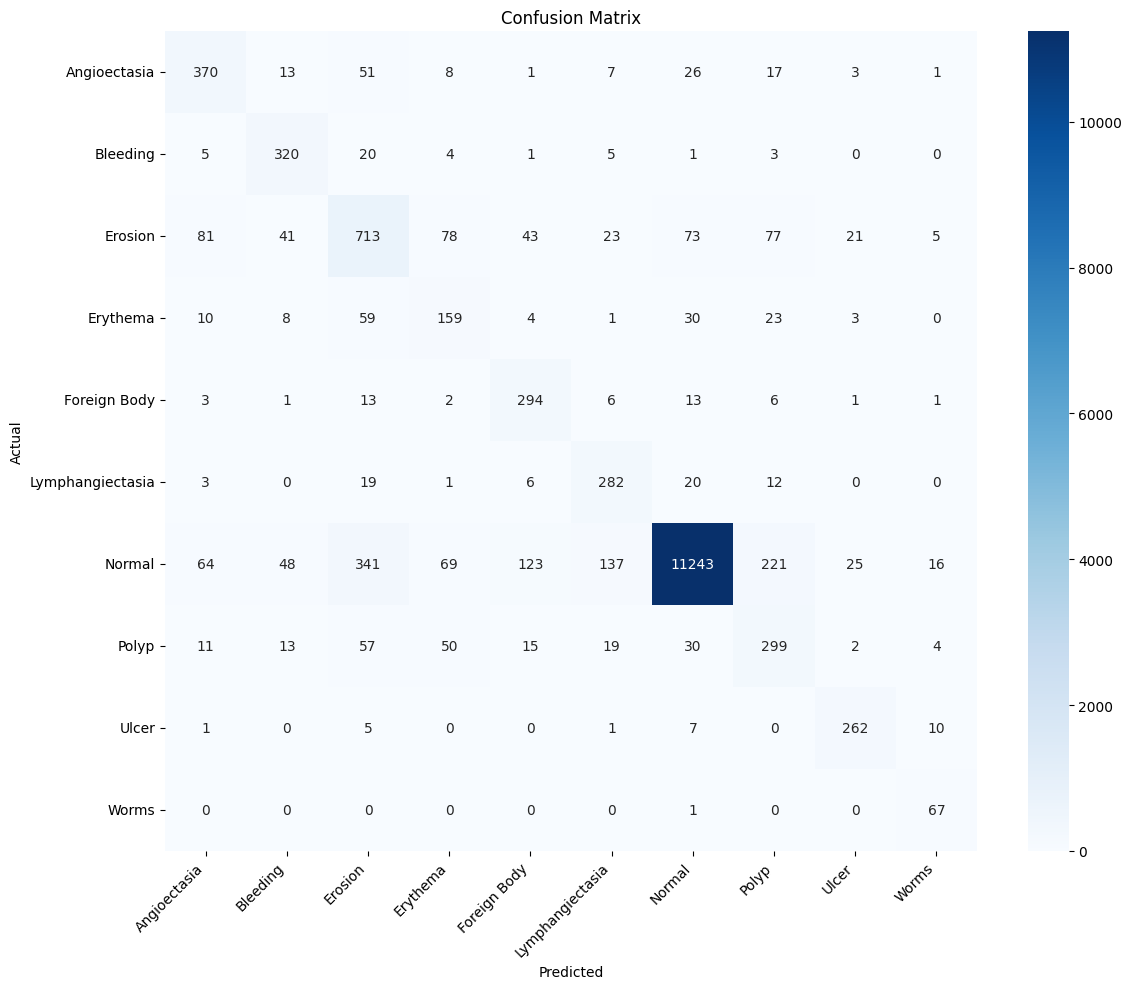

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12,10))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=train_ds.classes,
    yticklabels=train_ds.classes
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
for param in model.parameters():
    param.requires_grad = False

# unfreeze last feature block
for param in model.blocks[-1].parameters():
    param.requires_grad = True

# keep classifier trainable
for param in model.classifier.parameters():
    param.requires_grad = True

print("Fine-tuning layers activated")

Fine-tuning layers activated


In [21]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-6,
    weight_decay=1e-4
)

In [22]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=5
)

In [23]:
EPOCHS = 5
best_acc = 0

for epoch in range(EPOCHS):

    print(f"\nFineTune Epoch {epoch+1}/{EPOCHS}")

    # TRAIN
    model.train()
    running_loss = 0

    for imgs,labels in train_loader:

        imgs,labels = imgs.to(device),labels.to(device)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out,labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    print("Train Loss:", running_loss/len(train_loader))


    # VALIDATION
    model.eval()
    correct,total = 0,0

    with torch.no_grad():
        for imgs,labels in val_loader:
            imgs,labels = imgs.to(device),labels.to(device)
            preds = model(imgs).argmax(1)

            correct += (preds==labels).sum().item()
            total += labels.size(0)

    acc = correct/total
    print("Val Accuracy:", acc)


    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(),"best_model_finetuned.pth")
        print("Saved best fine-tuned model")


FineTune Epoch 1/5
Train Loss: 0.4100621160924384
Val Accuracy: 0.8780064468137863
Saved best fine-tuned model

FineTune Epoch 2/5
Train Loss: 0.4118620648387769
Val Accuracy: 0.8735432680386809

FineTune Epoch 3/5
Train Loss: 0.39777619684381144
Val Accuracy: 0.8801140590131415
Saved best fine-tuned model

FineTune Epoch 4/5
Train Loss: 0.3844703738150016
Val Accuracy: 0.8748450285147533

FineTune Epoch 5/5
Train Loss: 0.38908209010711586
Val Accuracy: 0.8755888916439375


In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

model.eval()

all_preds=[]
all_labels=[]

with torch.no_grad():
    for imgs,labels in val_loader:
        imgs=imgs.to(device)
        preds=model(imgs).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels,all_preds)

per_class = cm.diagonal()/cm.sum(axis=1)

df = pd.DataFrame({
    "Class": train_ds.classes,
    "Accuracy": per_class
}).sort_values("Accuracy",ascending=False)

df

,Class,Accuracy
9,Worms,0.985294
8,Ulcer,0.926573
6,Normal,0.923252
1,Bleeding,0.883008
4,Foreign Body,0.852941
5,Lymphangiectasia,0.813411
0,Angioectasia,0.750503
7,Polyp,0.654000
2,Erosion,0.613853
3,Erythema,0.518519


In [25]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

# ======================
# CONFIG
# ======================

PATIENT_FOLDER = "/kaggle/input/datasets/himanshurajput123/faahaa/61"

TOP_K = 20            # number of strongest frames per disease
CONF_THRESHOLD = 0.60 # detection threshold

# ======================
# LOAD FRAMES
# ======================

files = sorted([
    f for f in os.listdir(PATIENT_FOLDER)
    if f.lower().endswith((".jpg",".png",".jpeg"))
])

print("Total frames:", len(files))

# ======================
# MODEL PREDICTIONS
# ======================

model.eval()
results = []

with torch.no_grad():

    for f in files:

        img = Image.open(os.path.join(PATIENT_FOLDER,f)).convert("RGB")
        img_t = val_tf(img).unsqueeze(0).to(device)

        probs = F.softmax(model(img_t),1)[0].cpu().numpy()
        results.append(probs)

results = np.array(results)

# ======================
# AGGREGATE PATIENT RESULT
# ======================

print("\n===== PATIENT REPORT =====\n")

class_names = train_ds.classes
predictions = {}

for c in range(len(class_names)):

    scores = results[:,c]
    top_scores = np.sort(scores)[-TOP_K:]     # strongest frames
    score = np.mean(top_scores)               # avg of strongest

    if score > CONF_THRESHOLD:
        predictions[class_names[c]] = score

# ======================
# PRINT RESULT
# ======================

if len(predictions)==0:
    print("No abnormality detected")
else:
    for k,v in sorted(predictions.items(), key=lambda x:x[1], reverse=True):
        print(f"{k:<20} confidence = {v:.3f}")

Total frames: 9601

===== PATIENT REPORT =====

Worms                confidence = 1.000
Normal               confidence = 0.996
Polyp                confidence = 0.992
Ulcer                confidence = 0.990
Foreign Body         confidence = 0.970
Lymphangiectasia     confidence = 0.917
Bleeding             confidence = 0.916
Erosion              confidence = 0.664
Angioectasia         confidence = 0.631


In [26]:
import numpy as np
import torch
from sklearn.metrics import roc_curve

model.eval()

probs_all=[]
labels_all=[]

with torch.no_grad():
    for imgs,labels in val_loader:
        imgs=imgs.to(device)
        probs=torch.softmax(model(imgs),1).cpu().numpy()
        probs_all.append(probs)
        labels_all.append(labels.numpy())

probs_all=np.vstack(probs_all)
labels_all=np.concatenate(labels_all)

thresholds_dict={}

for i,cls in enumerate(train_ds.classes):

    y_true=(labels_all==i).astype(int)
    y_scores=probs_all[:,i]

    fpr,tpr,th=roc_curve(y_true,y_scores)

    j_scores=tpr-fpr
    best=th[np.argmax(j_scores)]

    thresholds_dict[cls]=float(best)

print("\nOptimal thresholds:\n")
for k,v in thresholds_dict.items():
    print(f"{k:<20} {v:.3f}")


Optimal thresholds:

Angioectasia         0.059
Bleeding             0.081
Erosion              0.068
Erythema             0.017
Foreign Body         0.120
Lymphangiectasia     0.056
Normal               0.475
Polyp                0.057
Ulcer                0.053
Worms                0.289


In [27]:
final_thresholds = {
    k:max(v,0.05)
    for k,v in thresholds_dict.items()
}

print("\nFinal thresholds:\n")
for k,v in final_thresholds.items():
    print(f"{k:<20} {v:.3f}")


Final thresholds:

Angioectasia         0.059
Bleeding             0.081
Erosion              0.068
Erythema             0.050
Foreign Body         0.120
Lymphangiectasia     0.056
Normal               0.475
Polyp                0.057
Ulcer                0.053
Worms                0.289


In [28]:
import numpy as np

print("\n===== CALIBRATED PATIENT REPORT =====\n")

predictions={}

for i,cls in enumerate(train_ds.classes):

    scores=results[:,i]
    top_scores=np.sort(scores)[-20:]
    score=np.mean(top_scores)

    if score > final_thresholds[cls]:
        predictions[cls]=score


if not predictions:
    print("No abnormality detected")
else:
    for k,v in sorted(predictions.items(),key=lambda x:x[1],reverse=True):
        print(f"{k:<20} confidence = {v:.3f}")


===== CALIBRATED PATIENT REPORT =====

Worms                confidence = 1.000
Normal               confidence = 0.996
Polyp                confidence = 0.992
Ulcer                confidence = 0.990
Foreign Body         confidence = 0.970
Lymphangiectasia     confidence = 0.917
Bleeding             confidence = 0.916
Erosion              confidence = 0.664
Angioectasia         confidence = 0.631
Erythema             confidence = 0.111


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


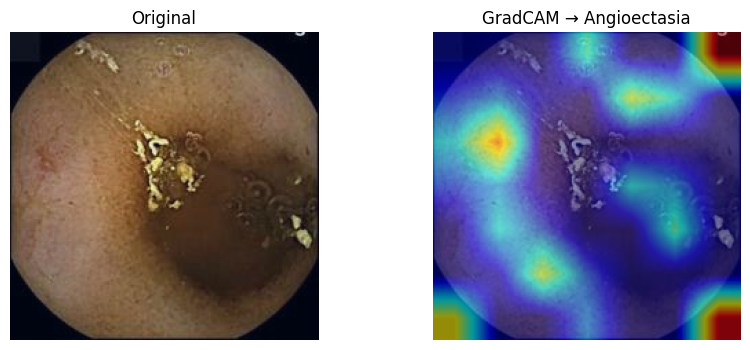

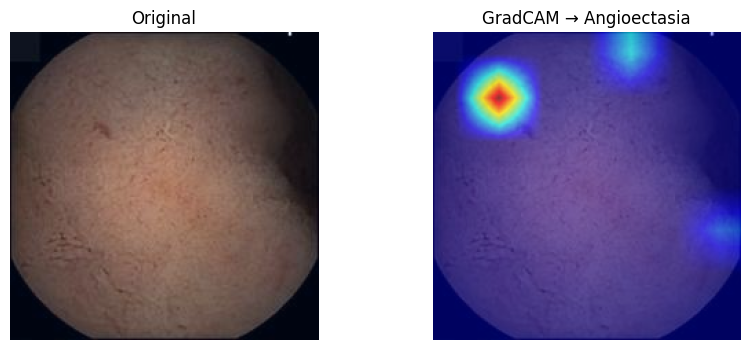

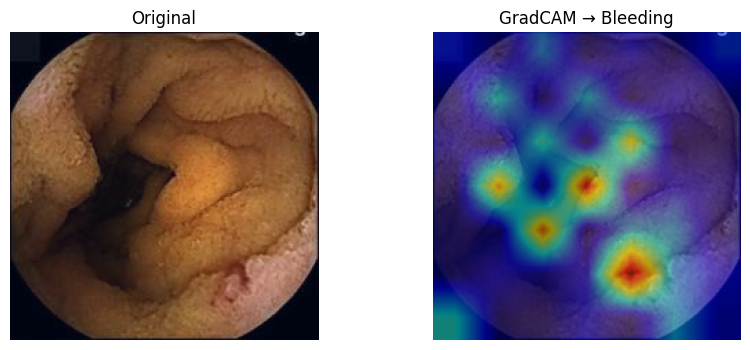

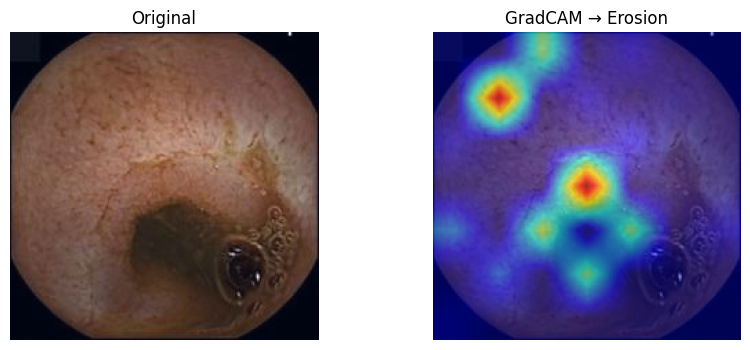

In [29]:
# ==============================
# GRADCAM — SINGLE CELL SCRIPT
# ==============================

!pip install grad-cam -q

import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# ------------------------------
# SELECT BEST LAYER FOR EFFICIENTNET
# ------------------------------
target_layer = model.blocks[-2][-1].conv_pwl
cam = GradCAM(model=model, target_layers=[target_layer])

# ------------------------------
# FUNCTION
# ------------------------------
def show_gradcam(idx):

    model.eval()

    img,label = val_ds[idx]

    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad=True

    grayscale_cam = cam(input_tensor=input_tensor)[0]

    rgb = img.permute(1,2,0).cpu().numpy()
    rgb = (rgb-rgb.min())/(rgb.max()-rgb.min()+1e-8)

    vis = show_cam_on_image(rgb,grayscale_cam,use_rgb=True)

    fig,ax = plt.subplots(1,2,figsize=(10,4))

    ax[0].imshow(rgb)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(vis)
    ax[1].set_title(f"GradCAM → {train_ds.classes[label]}")
    ax[1].axis("off")

    plt.show()


# ------------------------------
# SHOW MULTIPLE EXAMPLES
# ------------------------------

indices = [10,200,500,900]

for i in indices:
    show_gradcam(i)